In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as signal

def qdem(x):
    return np.angle(x[1:] * np.conj(x[:-1])) / (2 * np.pi)

In [287]:
def open_recording_as_raw(fname):
    """
    Open a HackRF or similar recording of I/Q data.
    """
    center_freq = int(filename.split('_')[-3])
    
    num_format = filename.split('_')[-1]
    type_ = None
    scale = 1.0
    if num_format.startswith('i8c'):
        type_ = np.int8
        scale = 1/2**7
    elif num_format.startswith('i16c'):
        type_ = np.int16
        scale = 1/2**15
    elif num_format.startswith('fc'):
        type_ = np.float32
        scale = 1.0
    else:
        raise Exception(f'Unknown recording number format {num_format} in file "{fname}"')
    
    # Read raw interleaved IQ data
    raw_data = np.memmap(filename, dtype=type_, mode='r')
    fs = int(filename.split('_')[-2])
    
    print(f'File: {fname}, sample count: {len(raw_data)} ({len(raw_data)/fs/2:.2f}) seconds)')

    return center_freq, fs, scale, raw_data

def open_recording_as_complex(fname, window_offset=0, window_size=1):
    """
    Open a HackRF or similar recording of I/Q data and narrow to a given window offset and size (in seconds)
    """
    center_freq, fs, scale, raw_data = open_recording_as_raw(fname)
    
    # in seconds
    start = int(window_offset * fs * 2)
    end = int(start + window_size * fs * 2)
    raw_data = raw_data[start:end]

    # Reshape into complex values: I (even indices), Q (odd indices)
    iq_data = raw_data.astype(np.float32) * scale
    iq_data = iq_data[0::2] + 1j * iq_data[1::2]
    return center_freq, fs, iq_data

In [242]:
def detect_frequencies(data, freqs, fs, bandwidth=5000, threshold_db=15):
    """
    Detect rate that a given complex sample contains certain frequencies (from a given center frequency) above a certain gain.
    """
    window = np.hanning(len(data))
    windowed_data = data * window

    spectrum = np.fft.fftshift(np.fft.fft(windowed_data))
    frequencies = np.fft.fftshift(np.fft.fftfreq(len(spectrum), d=1/fs))  # adjust for sample rate
    power = 20 * np.log10(np.abs(spectrum) + 1e-10)  # in dB

    result = []
    for freq in freqs:
        mask = (frequencies >= (freq - bandwidth/2)) & (frequencies <= (freq + bandwidth/2))
        band = power[mask]
        if len(band) > 0:
            result.append(np.sum(band >= threshold_db)/len(band))
        else:
            result.append(0)
    
    return np.array(result)

In [307]:
def detect_dpu_messages(fname, debug_print=False):
    # messages last about 0.5 seconds, so we can sample every 0.2 seconds or so
    center_freq, fs, scale, raw_data = open_recording_as_raw(fname)

    # truncate data for testing
    # raw_data = raw_data[:fs * 20 * 2]

    sample_interval = int(0.2 * fs)
    sample_len = 2024 * 8

    detection = []

    print(f'Processing {len(raw_data)//2//sample_interval} raw samples...')
    # indices are for pairs of values
    for i in range(0, len(raw_data)//2, sample_interval):
        # Reshape into complex values: I (even indices), Q (odd indices)
        iq_data = raw_data[i*2:i*2+sample_len*2].astype(np.float32) * scale
        iq_data = iq_data[0::2] + 1j * iq_data[1::2]
        
        detected = detect_frequencies(iq_data, DPU_FREQS - center_freq, fs)
        seconds = i/fs

        if np.any(detected > 0.5):
            detection.append((seconds, detected))

            if debug_print:
                s = f'time: {seconds:5.1f}   DPUs:'
                for dpu in detected:
                    s += f' {dpu:.2f}'
                print(s)

    return detection

In [305]:
def draw_dpu_spectrogram(fname, start_time, duration):
    center_freq, fs, iq_data = open_recording_as_complex(fname, start_time, duration)
    
    chunk_size = 2048 * 8
    num_chunks = len(iq_data) // chunk_size
    
    channelset1 = (452.925, 452.95)
    channelset2 = (457.925, 457.95)
    bandwidth = 5e-3 # 5khz
    
    t = np.linspace(start_time, start_time + num_chunks * chunk_size / fs, num_chunks)
    freq1 = None
    freq2 = None
    mesh1 = []
    mesh2 = []
    for i in range(num_chunks):
        data = iq_data[i * chunk_size:(i + 1) * chunk_size]
        window = np.hanning(len(data))
        windowed_data = data * window
        
        # FFT
        spectrum = np.fft.fftshift(np.fft.fft(windowed_data))
        raw_frequencies = np.fft.fftshift(np.fft.fftfreq(len(spectrum), d=1/fs))  # adjust for sample rate
        frequencies = (raw_frequencies + center_freq)/1e6 # in MHz
        power = 20 * np.log10(np.abs(spectrum) + 1e-10)  # in dB
    
        f_min = channelset1[0] - 0.0125 * .5
        f_max = channelset1[1] + 0.0125 * .5
        mask = (frequencies >= f_min) & (frequencies <= f_max)
    
        filtered_freq = frequencies[mask]
        filtered_power = power[mask]
    
        if freq1 is None:
            freq1 = filtered_freq
        mesh1.append(filtered_power)
    
        f_min = channelset2[0] - 0.0125 * .5
        f_max = channelset2[1] + 0.0125 * .5
        mask = (frequencies >= f_min) & (frequencies <= f_max)
    
        filtered_freq = frequencies[mask]
        filtered_power = power[mask]
    
        if freq2 is None:
            freq2 = filtered_freq
        mesh2.append(filtered_power)
    
    mesh1 = np.array(mesh1).T
    mesh2 = np.array(mesh2).T
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    mesh_mappable1 = ax1.pcolormesh(t, freq1, mesh1, vmin=-40, vmax=40)
    
    ax1.set(title=f'Frequency Spectrum', ylabel="Frequency (+452. MHz)", xlabel="Time (sec)")
    ax1.ticklabel_format(useOffset=False)
    yvals = np.array([452.9250, 452.9375, 452.9500])
    ax1.set_yticks(yvals, ['DPU ch1 (.9250)', 'HOT (.9375)', 'DPU ch2 (.9500)'])
    
    fig.colorbar(mesh_mappable1, ax=ax1)
    
    mesh_mappable2 = ax2.pcolormesh(t, freq2, mesh2, vmin=-40, vmax=40)
    
    ax2.set(title=f'Frequency Spectrum2', ylabel="Frequency (+457. MHz)", xlabel="Time (sec)")
    ax2.ticklabel_format(useOffset=False)
    yvals = np.array([457.9250, 457.9375, 457.9500])
    ax2.set_yticks(yvals, ['DPU ch3 (.9250)', 'EOT (.9375)', 'DPU ch4 (.9500)'])
    
    fig.colorbar(mesh_mappable2, ax=ax2)
    plt.show()

In [187]:
DPU_FREQS = np.array([452_925_000, 452_950_000, 457_925_000, 457_950_000])

In [194]:
center_freq, fs, iq_data = open_recording_as_complex('recordings/gqrx_20250804_210302_455500000_6000000_fc.raw', 17, 3)

File: recordings/gqrx_20250804_210302_455500000_6000000_fc.raw, sample count: 1031798784 (85.98) seconds)


In [243]:
max_data_size = 2048 * 4
chunk_index = int(fs/max_data_size * 1.0)
data = iq_data[chunk_index * max_data_size:(chunk_index + 1) * max_data_size]

detect_frequencies(data, DPU_FREQS - center_freq, fs)

array([0., 0., 0., 1.])

In [309]:
detections = detect_dpu_messages('recordings/gqrx_20250804_210302_455500000_6000000_fc.raw', debug_print=True)

File: recordings/gqrx_20250804_210302_455500000_6000000_fc.raw, sample count: 1031798784 (85.98) seconds)
Processing 429 raw samples...
time:  17.8   DPUs: 0.00 0.00 0.00 0.64
time:  18.0   DPUs: 0.00 0.00 0.00 0.93
time:  18.2   DPUs: 0.00 0.00 0.00 0.93
time:  24.0   DPUs: 0.00 0.00 0.00 0.71
time:  29.0   DPUs: 0.00 0.00 0.00 0.57
time:  29.2   DPUs: 0.00 0.00 0.00 1.00
time:  35.0   DPUs: 0.00 0.14 0.00 1.00
time:  35.2   DPUs: 0.00 0.00 0.00 1.00
time:  38.0   DPUs: 0.00 0.00 0.00 1.00
time:  43.8   DPUs: 0.00 0.07 0.00 1.00
time:  64.0   DPUs: 0.08 0.00 0.00 1.00
time:  67.6   DPUs: 0.00 0.00 0.00 1.00
time:  70.6   DPUs: 0.00 0.00 0.00 1.00
time:  76.4   DPUs: 0.00 0.00 0.00 0.57


File: recordings/gqrx_20250804_210302_455500000_6000000_fc.raw, sample count: 1031798784 (85.98) seconds)


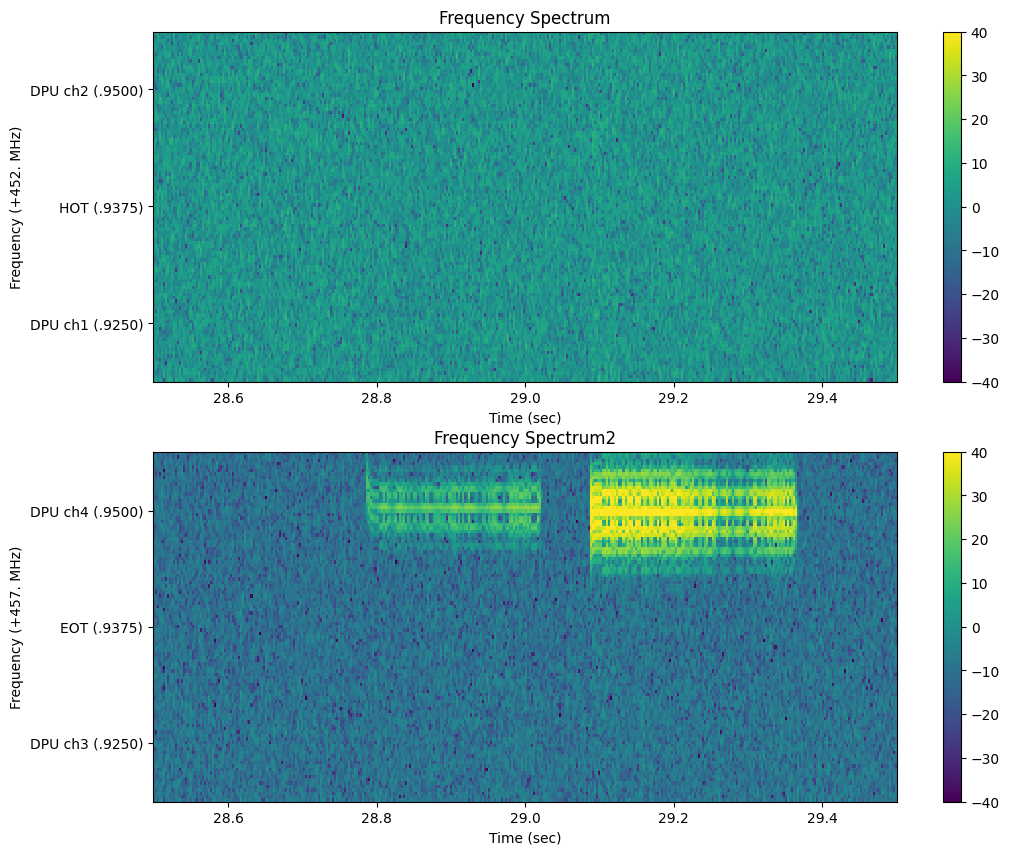

In [306]:
draw_dpu_spectrogram('recordings/gqrx_20250804_210302_455500000_6000000_fc.raw', 28.5, 1)

[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 0]


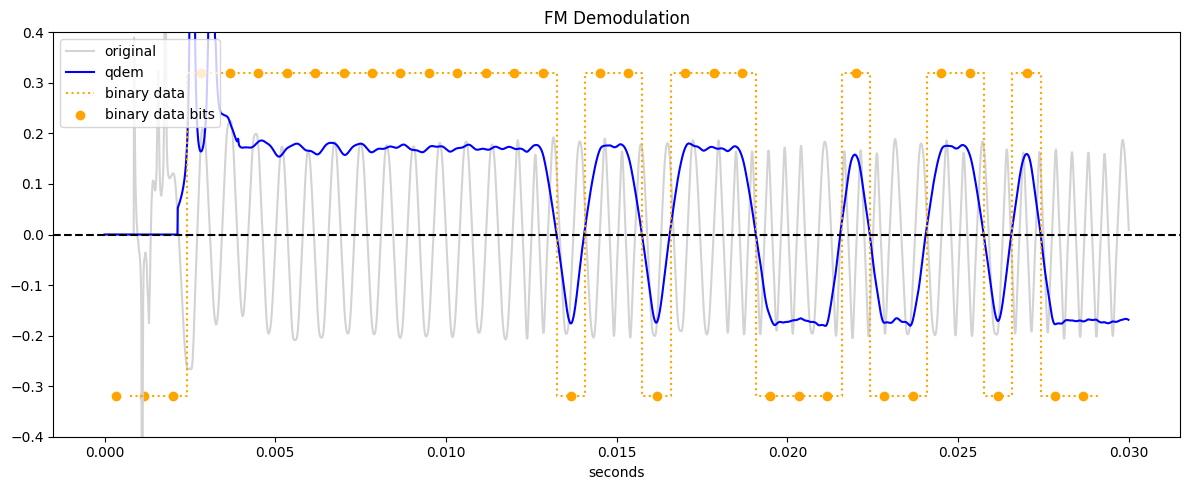

In [144]:
target_freq = int(457.95e6)
start_time = .98 # in seconds
duration = .03 # in seconds

if start_time * fs > len(iq_data):
    raise ValueError('start time after end of sample')

data = iq_data[int(start_time * fs):int((start_time + duration) * fs)]

t = np.arange(len(data))
mixed = data * np.exp(-2j * np.pi * ((target_freq - center_freq) / fs) * t)

factor = 64
new_fs = fs // factor
downsampled = signal.decimate(mixed, factor)

fir_lp2 = signal.firwin(81, cutoff=3000, fs=new_fs)
fskbb = signal.lfilter(fir_lp2, 1.0, downsampled)

recovered_signal = qdem(fskbb) * 10
recovered_signal[:81] = 0

intermediate = recovered_signal
data = recovered_signal

# Apply low-pass FIR filter using firwin and lfilter
# fir_lp1 = signal.firwin(5001, cutoff=3000, fs=new_fs)
# low_passed = signal.lfilter(fir_lp1, 1.0, data)
low_passed = data

t = np.arange(len(low_passed))
mixed = low_passed * np.exp(-2j * np.pi * (-1700 / new_fs) * t)

fir_lp2 = signal.firwin(201, cutoff=800, fs=new_fs)
fskbb = signal.lfilter(fir_lp2, 1.0, mixed)
# fskbb = mixed

recovered_signal = qdem(fskbb) * 40
recovered_signal[:201] = 0

baudrate = 1200
offset = new_fs / baudrate * 0.4
num_samples = int(len(recovered_signal) / new_fs * baudrate)
start = offset
end = offset + (num_samples - 1) * new_fs/baudrate
baud = np.linspace(start, end, num_samples)
# print(f'{num_samples=}, {offset=}, {baud[1]-baud[0]=}, {baud=}')
baudtime = baud/new_fs

# data decoding
bin_data = ((np.sign(recovered_signal[baud.astype(int)]) + 1)/2).astype(int)
print(bin_data)

plt.figure(figsize=(12, 5))

plt.plot(np.linspace(0, len(intermediate)/new_fs, len(intermediate)), intermediate, color='lightgray', label='original')
plt.plot(np.linspace(0, len(recovered_signal)/new_fs, len(recovered_signal)), recovered_signal, color='blue', label='qdem')

display_max = 0.4
bin_display = ((bin_data*2 - 1)*display_max*0.8)
plt.step(baudtime + 1/baudrate/2, bin_display, linestyle=':', color='orange', label='binary data')
plt.scatter(baudtime, bin_display, color='orange', label='binary data bits')

plt.axhline(0, color='black', linestyle='--')
plt.ylim(-display_max, display_max)
plt.xlabel('seconds')
plt.title('FM Demodulation')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [109]:
d = ''.join(map(str, bin_data.tolist()))
print(f'{d=}')
frame_sync = '0110111000100110100001'
search = frame_sync
print(f'{frame_sync=} {search=}')

start_index = 0
while True:
    index = d.find(search, start_index)
    if index == -1:  # Substring not found
        break
    print(f'FOUND {index=} str: {d[index-10:index+len(search)+10]}')
    start_index = index + 1  # Start searching from the next character

d='00111111111111101101110001001101000010101110001100010001101001101111110100001111101100001001001111100010100000011101011'
frame_sync='0110111000100110100001' search='0110111000100110100001'
FOUND index=15 str: 111111111101101110001001101000010101110001


In [466]:
frame_sync_nums = np.array([int(c) for c in frame_sync])
framesync = np.repeat((frame_sync_nums * 2) - 1, new_fs/baudrate)

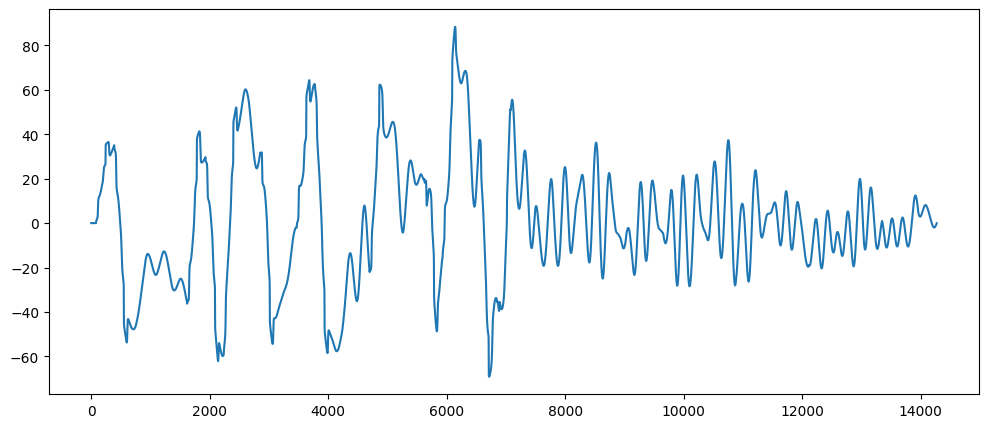

In [502]:
locs = np.convolve(recovered_signal, framesync[::-1])
# plt.hist(np.argsort(locs)[:-1000:-1])
plt.figure(figsize=(12, 5))
plt.plot(locs)

# Old old code

sample rate: 44100, audio duration: 87.36s


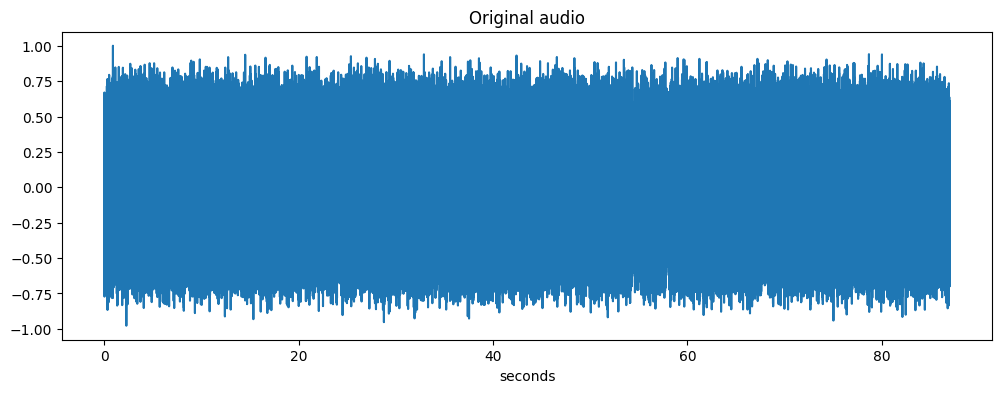

In [337]:
# wav_path = 'recordings/train3137_452.9250_2.wav'
wav_path = 'recordings/4579375_20250711_1206.wav'
fs, audio = wavfile.read(wav_path)
print(f'sample rate: {fs}, audio duration: {len(audio) / fs:.2f}s')

# If stereo, convert to mono
if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1)

# Normalize audio to float in [-1, 1]
if audio.dtype != np.float32 and audio.dtype != np.float64:
    audio = audio / np.max(np.abs(audio))

plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, len(audio)//fs, len(audio)), audio)
plt.title('Original audio')
plt.xlabel('seconds')
plt.show()

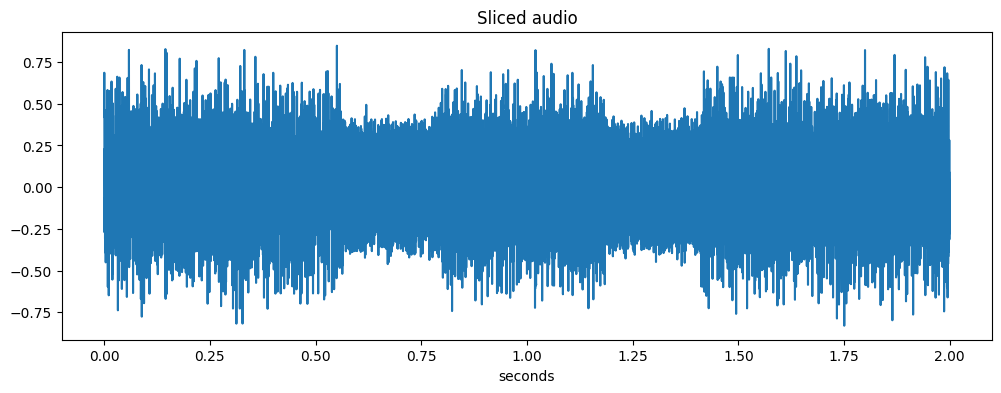

In [345]:
trim_start = 54
trim_end = trim_start + 2
trimmed_audio = audio[int(fs * trim_start):int(fs * trim_end)]

plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, len(trimmed_audio)/fs, len(trimmed_audio)), trimmed_audio)
plt.title('Sliced audio')
plt.xlabel('seconds')
plt.show()

[0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


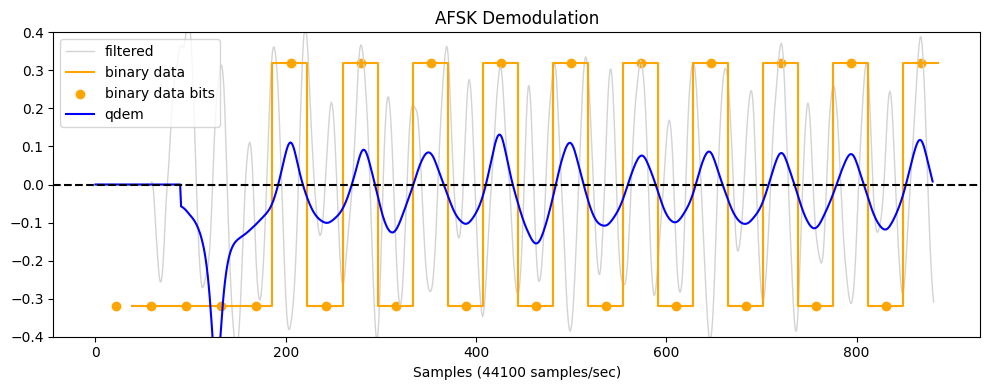

In [315]:
# Apply low-pass FIR filter using firwin and lfilter
fir_lp1 = signal.firwin(121, cutoff=10000, fs=fs)  # order 120
low_passed = signal.lfilter(fir_lp1, 1.0, trimmed_audio)

# Frequency shift (mixing)
t = np.arange(len(low_passed))
mixed = low_passed * np.exp(2j * np.pi * (-1550 / fs) * t)

# Apply a second low-pass filter to extract the baseband signal
fir_lp2 = signal.firwin(81, cutoff=600, fs=fs)  # order 80
fskbb = signal.lfilter(fir_lp2, 1.0, mixed)

# qdem (quadrature demodulation)
recovered_signal = qdem(fskbb) * 20
# initial portion of data is useless
recovered_signal[:90] = 0

baudrate = 1250
offset = fs / baudrate * 0.6
num_samples = int(len(trimmed_audio) / fs * baudrate) - 1
start = offset
end = offset + num_samples * fs/baudrate
baud = np.linspace(start, end, num_samples)

# data decoding
bin_data = ((np.sign(recovered_signal[baud.astype(int)]) + 1)/2).astype(int)
print(bin_data)


plt.figure(figsize=(10, 4))

# Plot the filtered waveform
plt.plot(low_passed, color='lightgray', linewidth=1, label='filtered')

display_max = 0.4
bin_display = ((bin_data*2 - 1)*display_max*0.8)
plt.step(baud + fs/baudrate/2, bin_display, color='orange', label='binary data')
plt.scatter(baud, bin_display, color='orange', label='binary data bits')

# plt.plot(np.real(fskbb))
# plt.plot(np.imag(fskbb))

plt.plot(recovered_signal, color='blue', label='qdem')

plt.axhline(0, color='black', linestyle='--')
plt.ylim(-display_max, display_max)
plt.title('AFSK Demodulation')
plt.xlabel(f'Samples ({fs} samples/sec)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
num_chunks = len(recovered_signal)//500
chunks = np.array(np.split(np.abs(recovered_signal)[:len(recovered_signal)//num_chunks*num_chunks], num_chunks))
np.sum(np.linalg.norm(chunks, axis=1, ord=np.inf) > 0.4) / num_chunks

np.float64(0.25)

# Old Cells

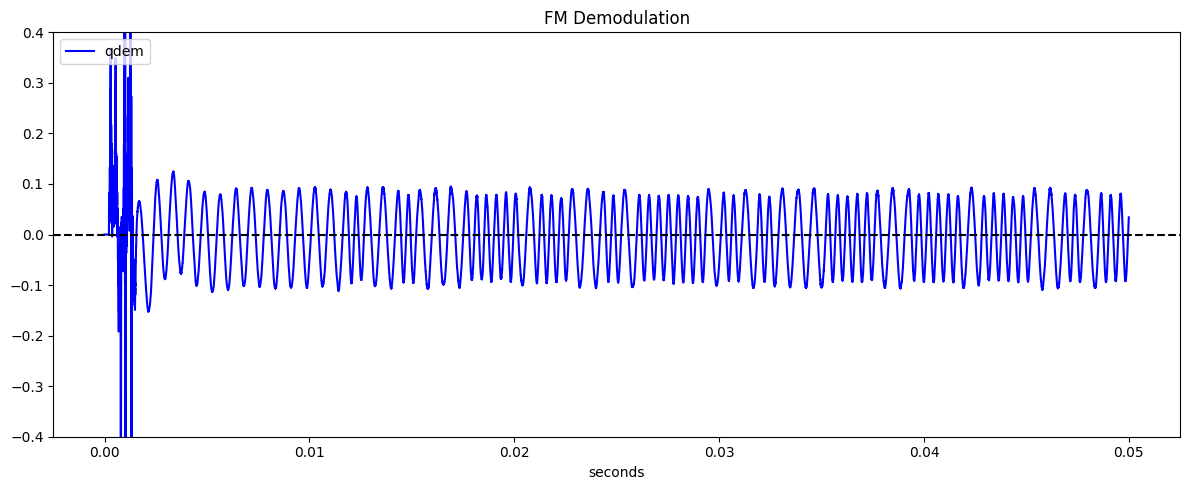

In [20]:
target_freq = int(457.95e6)
start_time = 2.98 # in seconds
duration = .05 # in seconds

if start_time * fs > len(iq_data):
    raise ValueError('start time after end of sample')

data = iq_data[int(start_time * fs):int((start_time + duration) * fs)]

t = np.arange(len(data))
mixed = data * np.exp(-2j * np.pi * ((target_freq - center_freq) / fs) * t)

factor = 16
new_fs = fs // factor
downsampled = signal.decimate(mixed, factor)

fir_lp2 = signal.firwin(81, cutoff=1000, fs=new_fs)  # order 80
fskbb = signal.lfilter(fir_lp2, 1.0, downsampled)

recovered_signal = qdem(fskbb) * 20
recovered_signal[:81] = 0

plt.figure(figsize=(12, 5))

display_max = 0.4
plt.plot(np.linspace(0, len(recovered_signal)/new_fs, len(recovered_signal)), recovered_signal, color='blue', label='qdem')

plt.axhline(0, color='black', linestyle='--')
plt.ylim(-display_max, display_max)
plt.xlabel('seconds')
plt.title('FM Demodulation')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

[1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1
 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0
 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0
 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0]


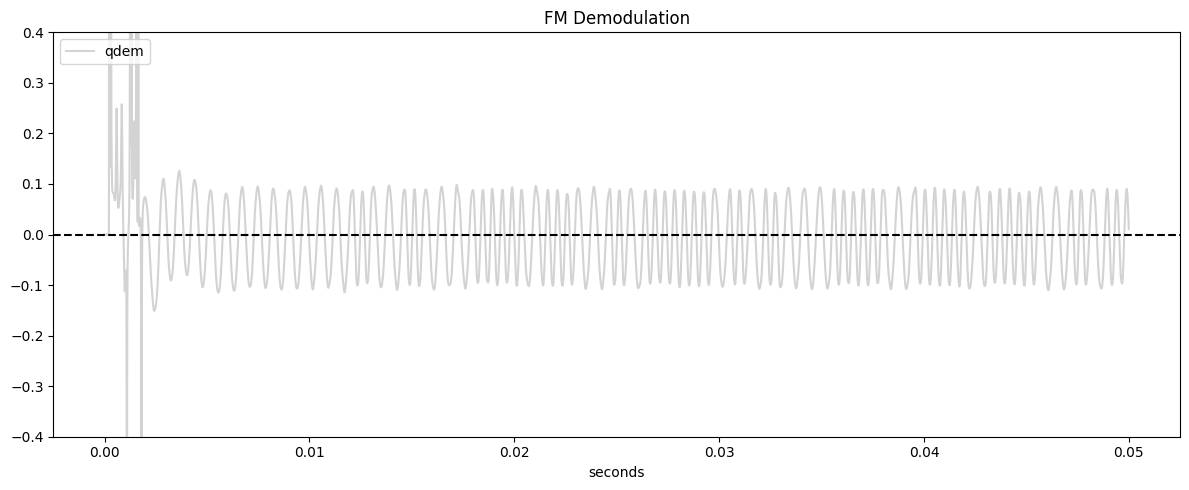

In [22]:
target_freq = int(457.95e6)
start_time = 2.98 # in seconds
duration = .05 # in seconds

if start_time * fs > len(iq_data):
    raise ValueError('start time after end of sample')

data = iq_data[int(start_time * fs):int((start_time + duration) * fs)]

t = np.arange(len(data))
mixed = data * np.exp(-2j * np.pi * ((target_freq - center_freq) / fs) * t)

factor = 16
new_fs = fs // factor
downsampled = signal.decimate(mixed, factor)

fir_lp2 = signal.firwin(301, cutoff=5000, fs=new_fs)  # order 80
fskbb = signal.lfilter(fir_lp2, 1.0, downsampled)

recovered_signal = qdem(fskbb) * 20
recovered_signal[:81] = 0

# recovered_signal = signal.lfilter(signal.firwin(1001, cutoff=1000, fs=new_fs), 1.0, recovered_signal) * 500

baudrate = 2650
offset = new_fs / baudrate * 0.7
num_samples = int(len(recovered_signal) / new_fs * baudrate) - 1
start = offset
end = offset + num_samples * new_fs/baudrate
baud = np.linspace(start, end, num_samples)
baudtime = baud/new_fs

# data decoding
bin_data = ((np.sign(recovered_signal[baud.astype(int)]) + 1)/2).astype(int)
print(bin_data)

plt.figure(figsize=(12, 5))

plt.plot(np.linspace(0, len(recovered_signal)/new_fs, len(recovered_signal)), recovered_signal, color='lightgray', label='qdem')

display_max = 0.4
bin_display = ((bin_data*2 - 1)*display_max*0.8)
# plt.step(baudtime + 1/baudrate/2, bin_display, color='orange', label='binary data')
# plt.scatter(baudtime, bin_display, color='orange', label='binary data bits')

plt.axhline(0, color='black', linestyle='--')
plt.ylim(-display_max, display_max)
plt.xlabel('seconds')
plt.title('FM Demodulation')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

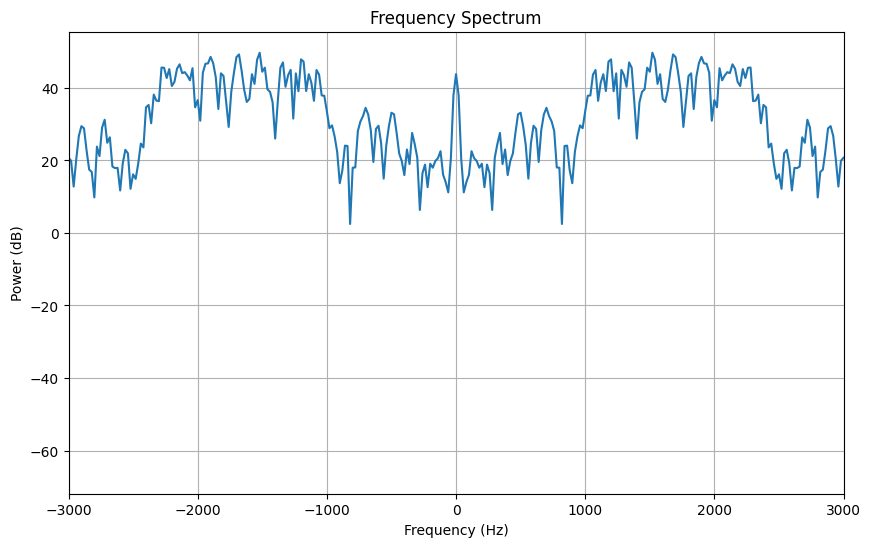

In [23]:
target_freq = int(457.95e6)
start_time = 2.98 # in seconds
duration = .05 # in seconds

if start_time * fs > len(iq_data):
    raise ValueError('start time after end of sample')

data = iq_data[int(start_time * fs):int((start_time + duration) * fs)]

t = np.arange(len(data))
mixed = data * np.exp(-2j * np.pi * ((target_freq - center_freq) / fs) * t)

factor = 16
new_fs = fs // factor
downsampled = signal.decimate(mixed, factor)

fir_lp2 = signal.firwin(81, cutoff=1000, fs=new_fs)  # order 80
fskbb = signal.lfilter(fir_lp2, 1.0, downsampled)

recovered_signal = qdem(fskbb) * 50
recovered_signal[:81] = 0

data = recovered_signal
window = np.hanning(len(data))
windowed_data = data * window

# FFT
spectrum = np.fft.fftshift(np.fft.fft(windowed_data))
frequencies = np.fft.fftshift(np.fft.fftfreq(len(spectrum), d=1/new_fs))  # adjust for sample rate
power = 20 * np.log10(np.abs(spectrum) + 1e-10)  # in dB

plt.figure(figsize=(10, 6))

plt.plot(frequencies, power)
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.xlim(-3000, 3000)
plt.grid(True)
plt.show()

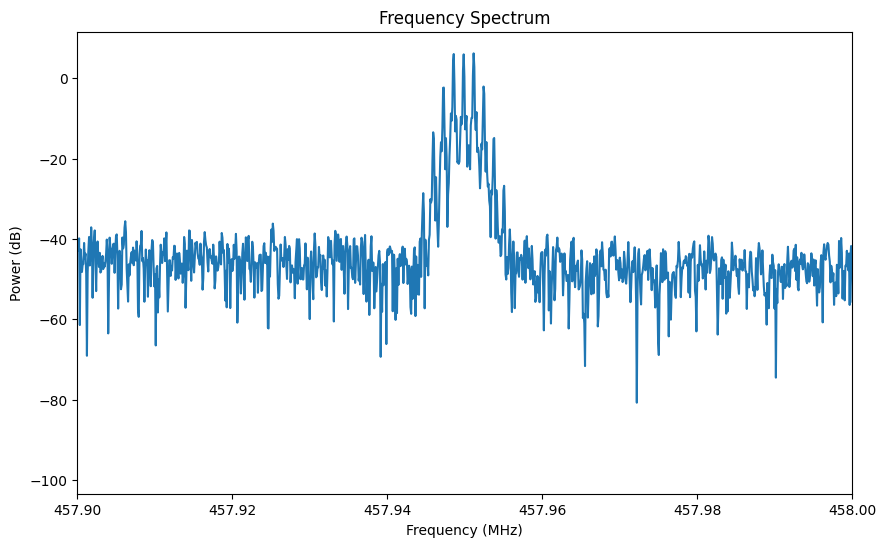

In [27]:
# Apply window to reduce spectral leakage
# max_data_size = fs//4
max_data_size = 2048 * 32
chunk_index = int(fs/max_data_size * 2.99)
data = iq_data[chunk_index * max_data_size:(chunk_index + 1) * max_data_size]
window = np.hanning(len(data))
windowed_data = data * window

# FFT
spectrum = np.fft.fftshift(np.fft.fft(windowed_data))
frequencies = np.fft.fftshift(np.fft.fftfreq(len(spectrum), d=1/fs))  # adjust for sample rate
power = 20 * np.log10(np.abs(spectrum) + 1e-10)  # in dB

plt.figure(figsize=(10, 6))

min_freq = 457.9
max_freq = min_freq + 0.1
plt.xlim(min_freq, max_freq)

plt.plot((frequencies + center_freq)/1e6, power)
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.show()